# Pre-Screening Task

Task Description:
Modify the second scenario in the following ways:

Add multiple changes to the reward distribution over time  
Introduce varying noise in the reward distribution  
Run this new simulator with different exploration algorithms and vizualize and compare their performance.

## Import Packages

In [26]:
from vowpalwabbit import pyvw
import random
import matplotlib.pyplot as plt
import pandas as pd
import itertools
import numpy as np

## Simulate Rewards

In [7]:
# VW tries to minimize loss/cost, therefore we will pass cost as -reward
USER_LIKED_ARTICLE = -1.0
USER_DISLIKED_ARTICLE = 0.0

In [8]:
def get_cost(context,action):
    if context['user'] == "Tom":
        if context['time_of_day'] == "morning" and action == 'politics':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'music':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE
    elif context['user'] == "Anna":
        if context['time_of_day'] == "morning" and action == 'sports':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'politics':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE

## Setup data pre-processing

In [9]:
# This function modifies (context, action, cost, probability) to VW friendly format
def to_vw_example_format(context, actions, cb_label = None):
    if cb_label is not None:
        chosen_action, cost, prob = cb_label
    example_string = ""
    example_string += "shared |User user={} time_of_day={}\n".format(context["user"], context["time_of_day"])
    for action in actions:
        if cb_label is not None and action == chosen_action:
            example_string += "0:{}:{} ".format(cost, prob)
        example_string += "|Action article={} \n".format(action)
    #Strip the last newline
    return example_string[:-1]

## Get decisions

In [10]:
def sample_custom_pmf(pmf):
    total = sum(pmf)
    scale = 1/total
    pmf = [x * scale for x in pmf]
    draw = random.random()
    sum_prob = 0.0
    for index, prob in enumerate(pmf):
        sum_prob += prob
        if(sum_prob > draw):
            return index, prob

In [12]:
def get_action(vw, context, actions):
    vw_text_example = to_vw_example_format(context,actions)
    pmf = vw.predict(vw_text_example)
    chosen_action_index, prob = sample_custom_pmf(pmf)
    return actions[chosen_action_index], prob

## Setup Simulation

In [19]:
users = ['Tom', 'Anna']
times_of_day = ['morning', 'afternoon', 'evening', 'night']
actions = ["politics", "sports", "music", "food", "finance", "health", "camping"]

def choose_user(users):
    return random.choice(users)

def choose_time_of_day(times_of_day):
    return random.choice(times_of_day)

# display preference matrix
def get_preference_matrix(cost_fun):
    def expand_grid(data_dict):
        rows = itertools.product(*data_dict.values())
        return pd.DataFrame.from_records(rows, columns=data_dict.keys())

    df = expand_grid({'users':users, 'times_of_day': times_of_day, 'actions': actions})
    df['cost'] = df.apply(lambda r: cost_fun({'user': r[0], 'time_of_day': r[1]}, r[2]), axis=1)

    return df.pivot_table(index=['users', 'times_of_day'], 
            columns='actions', 
            values='cost')

get_preference_matrix(get_cost)

actions             camping  finance  food  health  music  politics  sports
users times_of_day                                                         
Anna  afternoon         0.0      0.0   0.0     0.0    0.0      -1.0     0.0
      evening           0.0      0.0   0.0     0.0    0.0       0.0     0.0
      morning           0.0      0.0   0.0     0.0    0.0       0.0    -1.0
      night             0.0      0.0   0.0     0.0    0.0       0.0     0.0
Tom   afternoon         0.0      0.0   0.0     0.0   -1.0       0.0     0.0
      evening           0.0      0.0   0.0     0.0    0.0       0.0     0.0
      morning           0.0      0.0   0.0     0.0    0.0      -1.0     0.0
      night             0.0      0.0   0.0     0.0    0.0       0.0     0.0

In [20]:
def run_simulation_multiple_cost_functions(vw, num_iterations, users, times_of_day, actions, cost_functions, do_learn = True):
    cost_sum = 0.
    ctr = []

    start_counter = 1
    end_counter = start_counter + num_iterations
    for cost_function in cost_functions:
        for i in range(start_counter, end_counter):
            # 1. in each simulation choose a user
            user = choose_user(users)
            # 2. choose time of day for a given user
            time_of_day = choose_time_of_day(times_of_day)

            # Construct context based on chosen user and time of day
            context = {'user': user, 'time_of_day': time_of_day}

            # 3. Use the get_action function we defined earlier
            action, prob = get_action(vw, context, actions)

            # 4. Get cost of the action we chose
            cost = cost_function(context, action)
            cost_sum += cost

            if do_learn:
                # 5. Inform VW of what happened so we can learn from it
                vw_format = vw.parse(to_vw_example_format(context, actions, (action, cost, prob)),pyvw.vw.lContextualBandit)
                # 6. Learn
                vw.learn(vw_format)

            # We negate this so that on the plot instead of minimizing cost, we are maximizing reward
            ctr.append(-1*cost_sum/i)
        start_counter = end_counter
        end_counter = start_counter + num_iterations

    return ctr

In [21]:
def plot_ctr(num_iterations, ctr):
    plt.plot(range(1,num_iterations+1), ctr)
    plt.xlabel('num_iterations', fontsize=14)
    plt.ylabel('ctr', fontsize=14)
    plt.ylim([0,1])

## Setup second reward function

In [23]:
def get_cost_new1(context,action):
    if context['user'] == "Tom":
        if context['time_of_day'] == "morning" and (action == 'politics' or action == 'finance'):
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and (action == 'sports' or action == 'music'):
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "night" and action == 'health':
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE
    elif context['user'] == "Anna":
        if context['time_of_day'] == "morning" and action == 'sports':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "afternoon" and action == 'sports':
            return USER_LIKED_ARTICLE
        elif context['time_of_day'] == "evening" and (action == 'politics' or action == 'camping'):
            return USER_LIKED_ARTICLE
        else:
            return USER_DISLIKED_ARTICLE
        
get_preference_matrix(get_cost_new1)

actions             camping  finance  food  health  music  politics  sports
users times_of_day                                                         
Anna  afternoon         0.0      0.0   0.0     0.0    0.0       0.0    -1.0
      evening          -1.0      0.0   0.0     0.0    0.0      -1.0     0.0
      morning           0.0      0.0   0.0     0.0    0.0       0.0    -1.0
      night             0.0      0.0   0.0     0.0    0.0       0.0     0.0
Tom   afternoon         0.0      0.0   0.0     0.0   -1.0       0.0    -1.0
      evening           0.0      0.0   0.0     0.0    0.0       0.0     0.0
      morning           0.0     -1.0   0.0     0.0    0.0      -1.0     0.0
      night             0.0      0.0   0.0    -1.0    0.0       0.0     0.0

## Experiments

### Multiple changes to reward over time
Added 'evening' and 'night' to add more times of day  
Mixed up some of the actions to add more variance

#### with learning

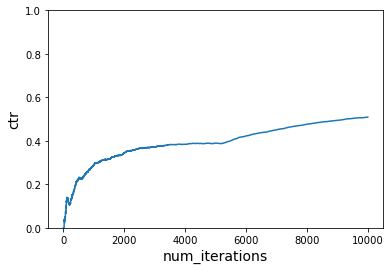

In [30]:
# use first reward function initially and then switch to second reward function

# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.2")

num_iterations_per_cost_func = 5000
cost_functions = [get_cost, get_cost_new1]
total_iterations = num_iterations_per_cost_func * len(cost_functions)

ctr = run_simulation_multiple_cost_functions(vw, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions)

plot_ctr(total_iterations, ctr)

#### without learning

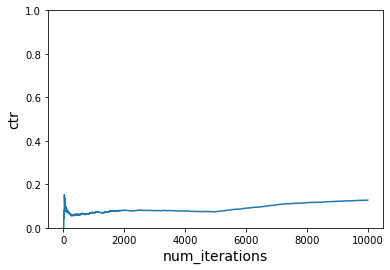

In [31]:
# Do not learn
# use first reward function initially and then switch to second reward function

# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.2")

num_iterations_per_cost_func = 5000
cost_functions = [get_cost, get_cost_new1]
total_iterations = num_iterations_per_cost_func * len(cost_functions)

ctr = run_simulation_multiple_cost_functions(vw, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions, do_learn=False)
plot_ctr(total_iterations, ctr)

### Add noise

Experiment 1:  
Add Noise with mu = 0, sigma = 0.1 and applying noise only to user likes

In [44]:
def get_cost_new2(context,action):
    noise = np.random.normal(0, 0.1)
    if context['user'] == "Tom":
        if context['time_of_day'] == "morning" and (action == 'politics' or action == 'finance'):
            return USER_LIKED_ARTICLE + noise
        elif context['time_of_day'] == "afternoon" and (action == 'sports' or action == 'music'):
            return USER_LIKED_ARTICLE + noise
        elif context['time_of_day'] == "night" and action == 'health':
            return USER_LIKED_ARTICLE + noise
        else:
            return USER_DISLIKED_ARTICLE
    elif context['user'] == "Anna":
        if context['time_of_day'] == "morning" and (action == 'sports' or action == 'food'):
            return USER_LIKED_ARTICLE + noise
        elif context['time_of_day'] == "afternoon" and action == 'sports':
            return USER_LIKED_ARTICLE + noise
        elif context['time_of_day'] == "evening" and (action == 'politics' or action == 'camping'):
            return USER_LIKED_ARTICLE + noise
        else:
            return USER_DISLIKED_ARTICLE
        
get_preference_matrix(get_cost_new2)

actions              camping   finance      food    health     music  \
users times_of_day                                                     
Anna  afternoon     0.000000  0.000000  0.000000  0.000000  0.000000   
      evening      -1.075984  0.000000  0.000000  0.000000  0.000000   
      morning       0.000000  0.000000 -0.939177  0.000000  0.000000   
      night         0.000000  0.000000  0.000000  0.000000  0.000000   
Tom   afternoon     0.000000  0.000000  0.000000  0.000000 -0.980265   
      evening       0.000000  0.000000  0.000000  0.000000  0.000000   
      morning       0.000000 -1.189858  0.000000  0.000000  0.000000   
      night         0.000000  0.000000  0.000000 -0.929591  0.000000   

actions             politics    sports  
users times_of_day                      
Anna  afternoon     0.000000 -0.936362  
      evening      -1.071305  0.000000  
      morning       0.000000 -0.814836  
      night         0.000000  0.000000  
Tom   afternoon     0.000000 -0.972262  
      evening       0.000000  0.000000  
      morning      -0.959729  0.000000  
      night         0.000000  0.000000

#### with learning

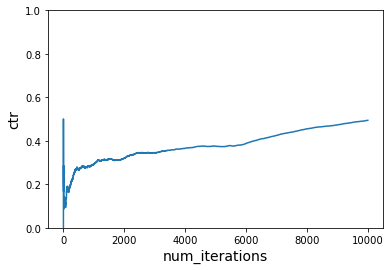

In [45]:
# use first reward function initially and then switch to second reward function

# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.2")

num_iterations_per_cost_func = 5000
cost_functions = [get_cost, get_cost_new2]
total_iterations = num_iterations_per_cost_func * len(cost_functions)

ctr = run_simulation_multiple_cost_functions(vw, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions)

plot_ctr(total_iterations, ctr)

#### without learning

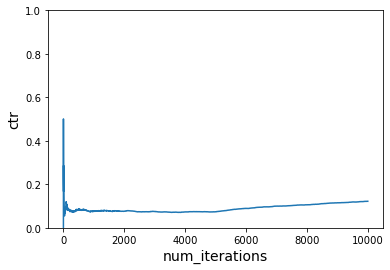

In [46]:
# Do not learn
# use first reward function initially and then switch to second reward function

# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.2")

num_iterations_per_cost_func = 5000
cost_functions = [get_cost, get_cost_new2]
total_iterations = num_iterations_per_cost_func * len(cost_functions)

ctr = run_simulation_multiple_cost_functions(vw, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions, do_learn=False)
plot_ctr(total_iterations, ctr)

Experiment 2:  
Add more noise

In [47]:
def get_cost_new3(context,action):
    noise = np.random.normal(0, 0.3)
    if context['user'] == "Tom":
        if context['time_of_day'] == "morning" and (action == 'politics' or action == 'finance'):
            return USER_LIKED_ARTICLE + noise
        elif context['time_of_day'] == "afternoon" and (action == 'sports' or action == 'music'):
            return USER_LIKED_ARTICLE + noise
        elif context['time_of_day'] == "night" and action == 'health':
            return USER_LIKED_ARTICLE + noise
        else:
            return USER_DISLIKED_ARTICLE
    elif context['user'] == "Anna":
        if context['time_of_day'] == "morning" and (action == 'sports' or action == 'food'):
            return USER_LIKED_ARTICLE + noise
        elif context['time_of_day'] == "afternoon" and action == 'sports':
            return USER_LIKED_ARTICLE + noise
        elif context['time_of_day'] == "evening" and (action == 'politics' or action == 'camping'):
            return USER_LIKED_ARTICLE + noise
        else:
            return USER_DISLIKED_ARTICLE
        
get_preference_matrix(get_cost_new3)

actions              camping   finance      food    health    music  politics  \
users times_of_day                                                              
Anna  afternoon     0.000000  0.000000  0.000000  0.000000  0.00000  0.000000   
      evening      -0.436658  0.000000  0.000000  0.000000  0.00000 -1.020422   
      morning       0.000000  0.000000 -1.053897  0.000000  0.00000  0.000000   
      night         0.000000  0.000000  0.000000  0.000000  0.00000  0.000000   
Tom   afternoon     0.000000  0.000000  0.000000  0.000000 -1.34401  0.000000   
      evening       0.000000  0.000000  0.000000  0.000000  0.00000  0.000000   
      morning       0.000000 -0.638361  0.000000  0.000000  0.00000 -1.169323   
      night         0.000000  0.000000  0.000000 -1.201892  0.00000  0.000000   

actions               sports  
users times_of_day            
Anna  afternoon    -1.105059  
      evening       0.000000  
      morning      -0.428015  
      night         0.000000  
Tom   afternoon    -0.957725  
      evening       0.000000  
      morning       0.000000  
      night         0.000000

#### with learning

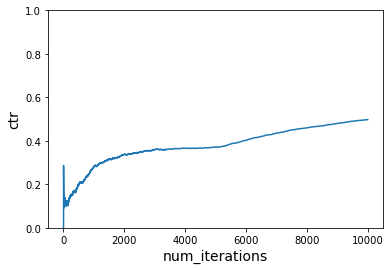

In [48]:
# use first reward function initially and then switch to second reward function

# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.2")

num_iterations_per_cost_func = 5000
cost_functions = [get_cost, get_cost_new3]
total_iterations = num_iterations_per_cost_func * len(cost_functions)

ctr = run_simulation_multiple_cost_functions(vw, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions)

plot_ctr(total_iterations, ctr)

#### without learning

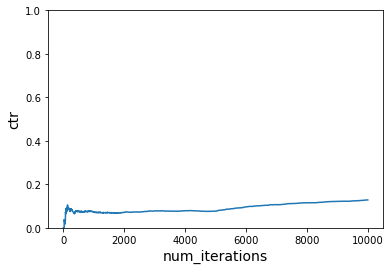

In [50]:
# Do not learn
# use first reward function initially and then switch to second reward function

# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.2")

num_iterations_per_cost_func = 5000
cost_functions = [get_cost, get_cost_new3]
total_iterations = num_iterations_per_cost_func * len(cost_functions)

ctr = run_simulation_multiple_cost_functions(vw, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions, do_learn=False)
plot_ctr(total_iterations, ctr)

Experiment 3:  
(For fun)
Add noise to both like and dislike(doesn't add anything)

In [51]:
def get_cost_new4(context,action):
    noise_l = np.random.normal(0, 0.3)
    noise_dl = np.random.normal(0, 0.01)
    if context['user'] == "Tom":
        if context['time_of_day'] == "morning" and (action == 'politics' or action == 'finance'):
            return USER_LIKED_ARTICLE + noise_l
        elif context['time_of_day'] == "afternoon" and (action == 'sports' or action == 'music'):
            return USER_LIKED_ARTICLE + noise_l
        elif context['time_of_day'] == "night" and action == 'health':
            return USER_LIKED_ARTICLE + noise_l
        else:
            return USER_DISLIKED_ARTICLE + noise_dl
    elif context['user'] == "Anna":
        if context['time_of_day'] == "morning" and (action == 'sports' or action == 'food'):
            return USER_LIKED_ARTICLE + noise_l
        elif context['time_of_day'] == "afternoon" and action == 'sports':
            return USER_LIKED_ARTICLE + noise_l
        elif context['time_of_day'] == "evening" and (action == 'politics' or action == 'camping'):
            return USER_LIKED_ARTICLE + noise_l
        else:
            return USER_DISLIKED_ARTICLE + noise_dl
        
get_preference_matrix(get_cost_new4)

actions              camping   finance      food    health     music  \
users times_of_day                                                     
Anna  afternoon    -0.010522  0.000765 -0.008407 -0.026301  0.009862   
      evening      -0.976920 -0.020849  0.010504  0.010478  0.009680   
      morning       0.011678  0.008247 -1.389839  0.003149 -0.001938   
      night         0.013787 -0.003575 -0.007841  0.005428 -0.017730   
Tom   afternoon     0.022363  0.013783  0.019801 -0.009127 -1.097384   
      evening       0.010512 -0.008964  0.027405 -0.011593 -0.010384   
      morning       0.014462 -1.208573 -0.022297 -0.009285  0.008327   
      night        -0.020203  0.023190 -0.011769 -1.054323  0.014116   

actions             politics    sports  
users times_of_day                      
Anna  afternoon    -0.012167 -1.108746  
      evening      -0.770499  0.001802  
      morning      -0.005302 -1.207073  
      night        -0.002387 -0.010423  
Tom   afternoon     0.007330 -0.877645  
      evening       0.013142  0.010672  
      morning      -1.318329 -0.010248  
      night         0.025179  0.016343

#### with learning

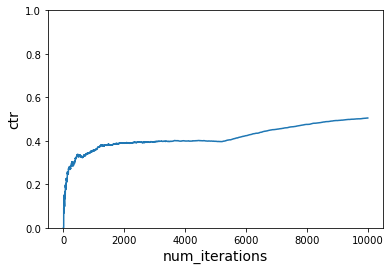

In [52]:
# use first reward function initially and then switch to second reward function

# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.2")

num_iterations_per_cost_func = 5000
cost_functions = [get_cost, get_cost_new4]
total_iterations = num_iterations_per_cost_func * len(cost_functions)

ctr = run_simulation_multiple_cost_functions(vw, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions)

plot_ctr(total_iterations, ctr)

#### without learning

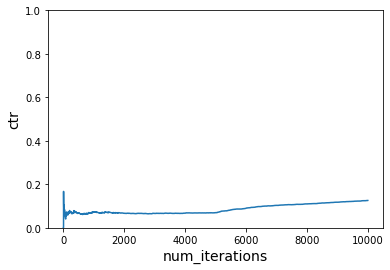

In [53]:
# Do not learn
# use first reward function initially and then switch to second reward function

# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.2")

num_iterations_per_cost_func = 5000
cost_functions = [get_cost, get_cost_new4]
total_iterations = num_iterations_per_cost_func * len(cost_functions)

ctr = run_simulation_multiple_cost_functions(vw, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions, do_learn=False)
plot_ctr(total_iterations, ctr)

### Using different exploration methods

#### Explore-First

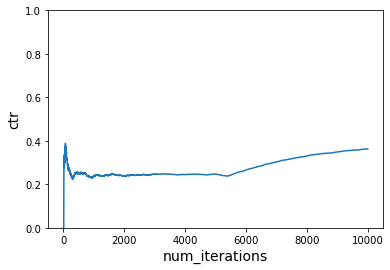

In [63]:
# Explore First
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --first 2")

num_iterations_per_cost_func = 5000
cost_functions = [get_cost, get_cost_new3]
total_iterations = num_iterations_per_cost_func * len(cost_functions)

ctr = run_simulation_multiple_cost_functions(vw, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions)

plot_ctr(total_iterations, ctr)

#### Epsilon-Greedy

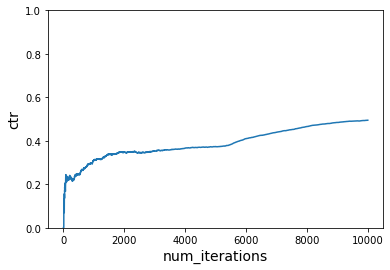

In [65]:
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.2")

num_iterations_per_cost_func = 5000
cost_functions = [get_cost, get_cost_new3]
total_iterations = num_iterations_per_cost_func * len(cost_functions)

ctr = run_simulation_multiple_cost_functions(vw, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions)

plot_ctr(total_iterations, ctr)

#### Bagging Explorer

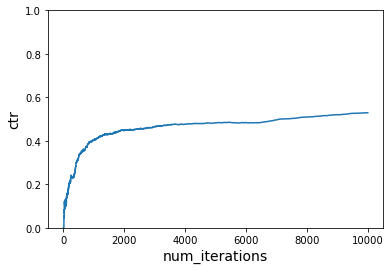

In [69]:
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --bag 5")

num_iterations_per_cost_func = 5000
cost_functions = [get_cost, get_cost_new3]
total_iterations = num_iterations_per_cost_func * len(cost_functions)

ctr = run_simulation_multiple_cost_functions(vw, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions)

plot_ctr(total_iterations, ctr)

#### Softmax Explorer

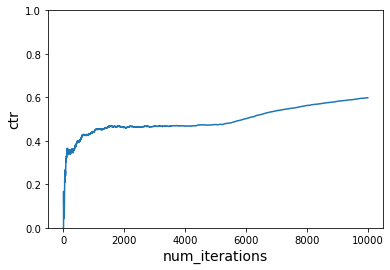

In [70]:
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --softmax --lambda 10")

num_iterations_per_cost_func = 5000
cost_functions = [get_cost, get_cost_new3]
total_iterations = num_iterations_per_cost_func * len(cost_functions)

ctr = run_simulation_multiple_cost_functions(vw, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions)

plot_ctr(total_iterations, ctr)

#### RND Explorer

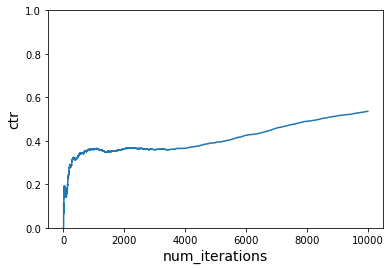

In [71]:
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --rnd 3 --epsilon 0.025")

num_iterations_per_cost_func = 5000
cost_functions = [get_cost, get_cost_new3]
total_iterations = num_iterations_per_cost_func * len(cost_functions)

ctr = run_simulation_multiple_cost_functions(vw, num_iterations_per_cost_func, users, times_of_day, actions, cost_functions)

plot_ctr(total_iterations, ctr)

## Summary

In general, adding noise to reward increases the performance of the exploration model. A lot of work has been done in this domain and the experiments above show the same.  
  
The best explorer for this is seemingly the SoftMax Explorer.